In [3]:
import sys
sys.path.insert(1, '/home/glenn/src/latent_ode/')
from generate_timeseries import *

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
%matplotlib inline

In [29]:
init = 0
# final = 1

In [30]:
tmax = 500
tmin = 0
xs = np.arange(tmin, tmax)

In [31]:
xs = np.sort(np.random.choice(xs, 100))

In [32]:
xs

array([  2,  13,  19,  26,  30,  35,  44,  59,  65,  66,  84,  89,  93,
        97, 101, 103, 109, 110, 112, 115, 124, 131, 142, 143, 147, 148,
       157, 159, 160, 165, 166, 174, 177, 193, 197, 205, 209, 209, 217,
       222, 223, 235, 264, 265, 268, 268, 275, 276, 287, 291, 293, 304,
       309, 315, 319, 323, 324, 325, 329, 331, 331, 334, 337, 341, 343,
       346, 348, 357, 362, 365, 368, 375, 384, 385, 389, 392, 396, 401,
       416, 419, 426, 428, 434, 444, 446, 456, 458, 462, 462, 469, 475,
       480, 481, 484, 485, 486, 495, 496, 496, 499])

In [37]:
generate_periodic(xs[0:1], init_freq=0.1, init_amplitude=init, starting_point=0, phi_offset=0.)

array([[2., 0.]])

In [38]:
f = Periodic_1d()

In [73]:
x = f.sample_traj(xs)
x_np = dataset.squeeze().detach().cpu().numpy()

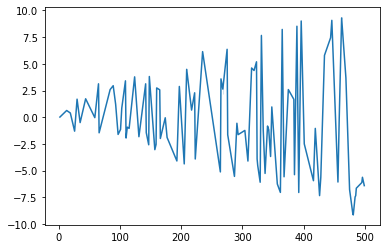

In [74]:
sns.lineplot(x=xs, y=x_np)

In [81]:
l = int(x.size(1)*0.8)

In [89]:
x_train = x[0][:l]
x_test = x[0][l:]